In [7]:
# automatically reload edited source code
%load_ext autoreload
%autoreload 2

# external package imports
import numpy as np
import pandas as pd
import os, pdb, glob, time, argparse
from os.path import exists, split, isdir, getsize
from sdo_clv_pipeline.sdo_plot import *

# internal package imports
from sdo_clv_pipeline.paths import root
from sdo_clv_pipeline.sdo_io import *
from sdo_clv_pipeline.sdo_process import *
from sdo_clv_pipeline.sdo_io import * 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# returns four sorted lists with the path to each of the file types
data_dir = os.path.abspath(os.path.join(os.getcwd(), "..", "data"))
con_files, mag_files, dop_files, aia_files = find_data(data_dir, "2014")
print(con_files)
print(len(con_files))
# print(con_files)
# print(mag_files)
# print(dop_files)
# print(aia_files)

File counts:
CON: 10
MAG: 10
DOP: 10
AIA: 11
[datetime.datetime(2014, 1, 10, 0, 0), datetime.datetime(2014, 1, 3, 0, 0), datetime.datetime(2014, 1, 11, 0, 0), datetime.datetime(2014, 1, 5, 0, 0), datetime.datetime(2014, 1, 6, 0, 0), datetime.datetime(2014, 1, 4, 0, 0), datetime.datetime(2014, 1, 9, 0, 0), datetime.datetime(2014, 1, 7, 0, 0)]
['c:\\Users\\srugi\\Documents\\sdo-clv-pipeline\\data\\hmi.ic_720s.20140103_000000_TAI.1.continuum.fits', 'c:\\Users\\srugi\\Documents\\sdo-clv-pipeline\\data\\hmi.ic_720s.20140104_000000_TAI.1.continuum.fits', 'c:\\Users\\srugi\\Documents\\sdo-clv-pipeline\\data\\hmi.ic_720s.20140105_000000_TAI.1.continuum.fits', 'c:\\Users\\srugi\\Documents\\sdo-clv-pipeline\\data\\hmi.ic_720s.20140106_000000_TAI.1.continuum.fits', 'c:\\Users\\srugi\\Documents\\sdo-clv-pipeline\\data\\hmi.ic_720s.20140107_000000_TAI.1.continuum.fits', 'c:\\Users\\srugi\\Documents\\sdo-clv-pipeline\\data\\hmi.ic_720s.20140109_000000_TAI.1.continuum.fits', 'c:\\Users\\srugi\\Docume

c:\Users\srugi\Documents\sdo-clv-pipeline\data


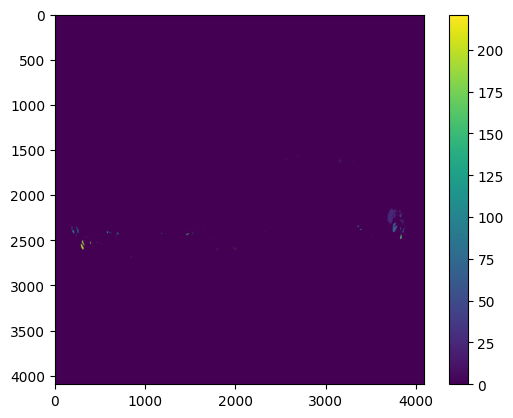

25
9686.0
trying to plot...
1.0706109


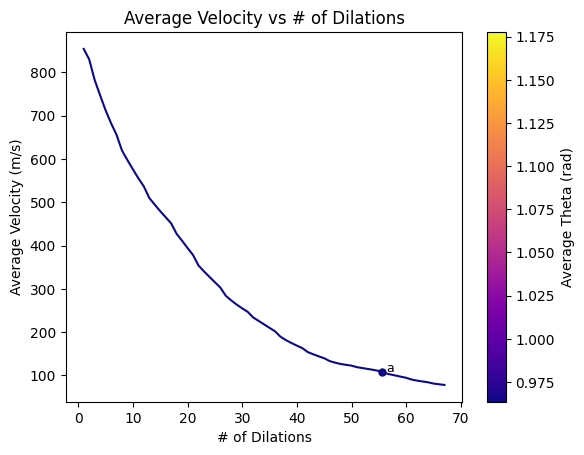

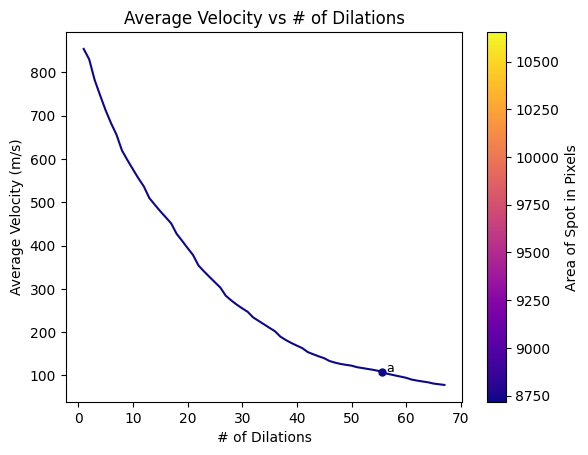

trying to plot...
1.0706109


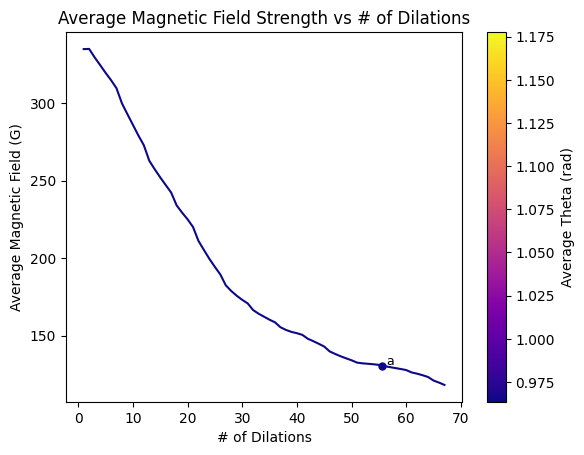

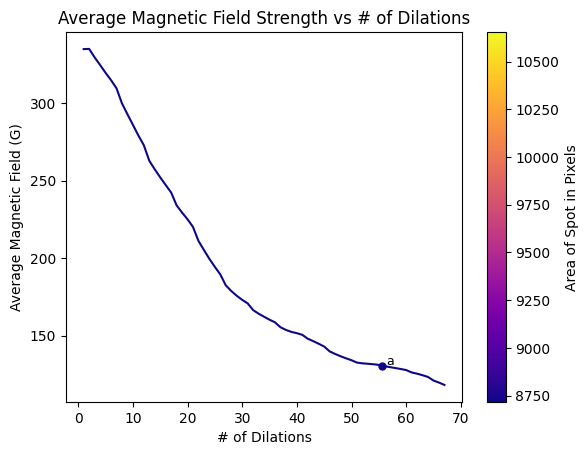

trying to plot...
1.0706109


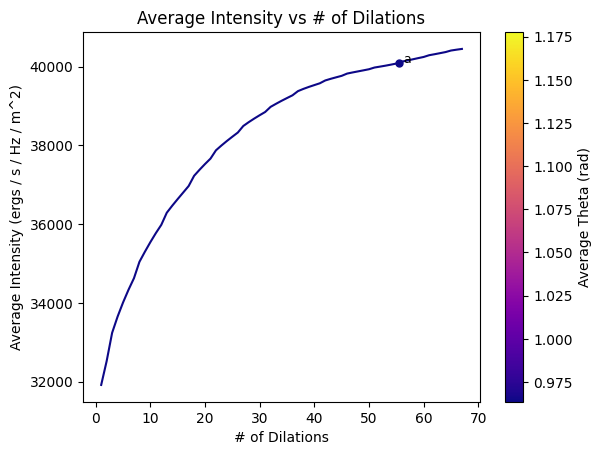

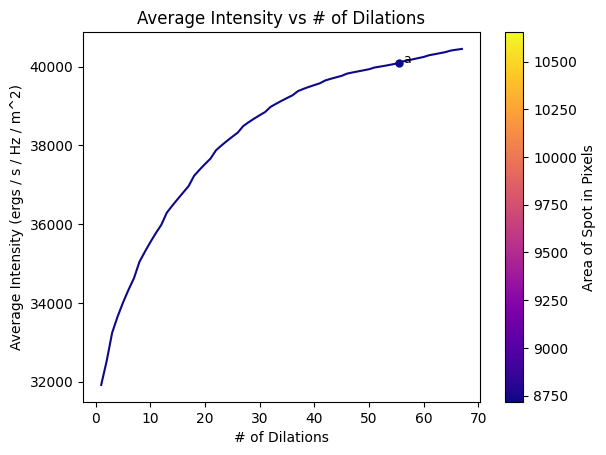

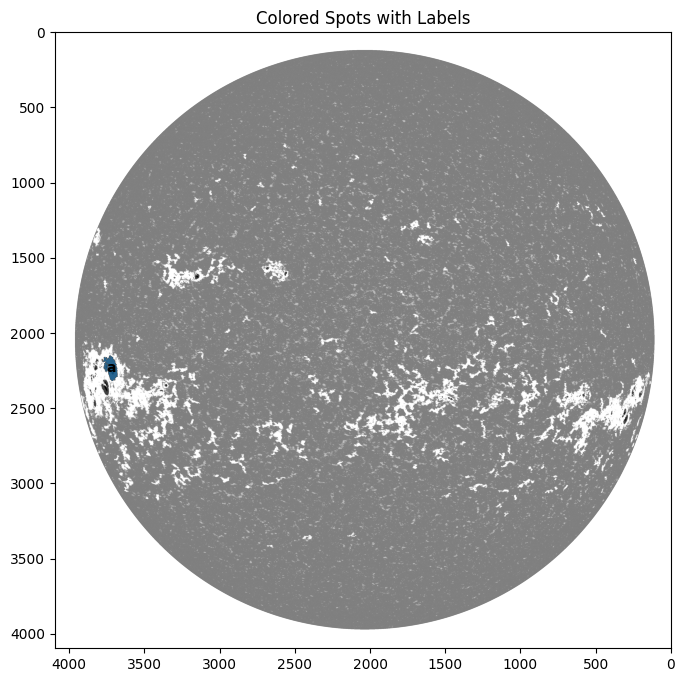

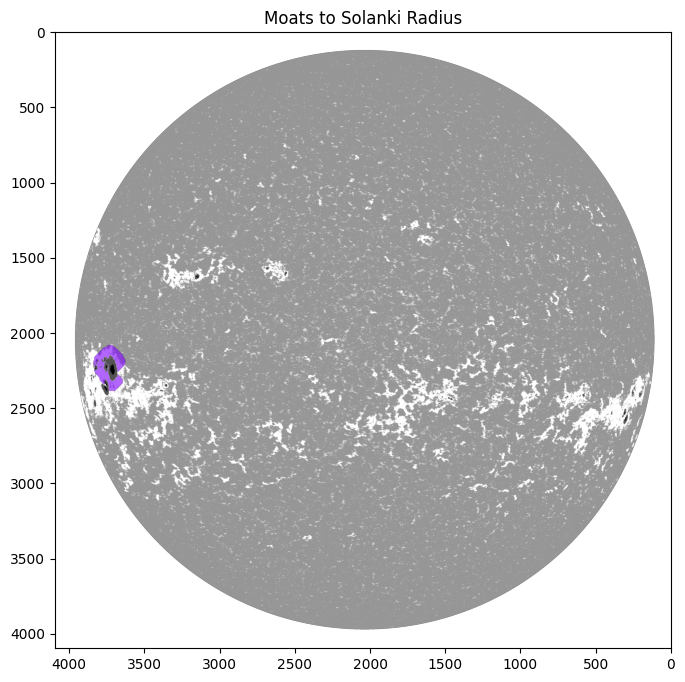

c:\Users\srugi\Documents\sdo-clv-pipeline\data


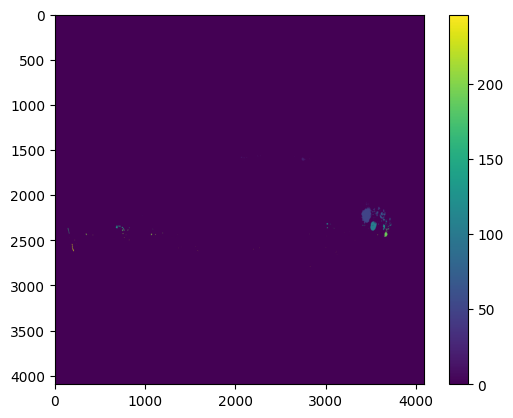

50
13319.0
trying to plot...
0.8270729


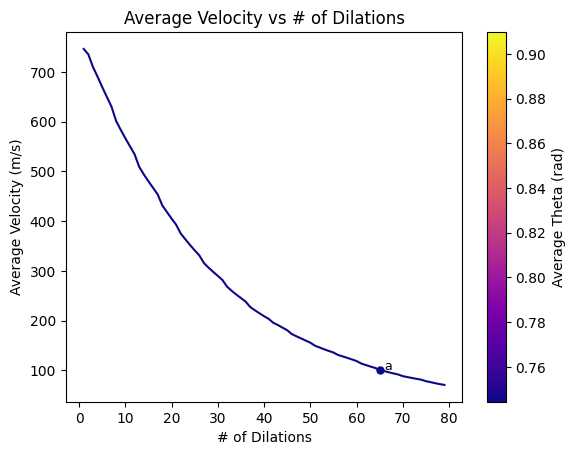

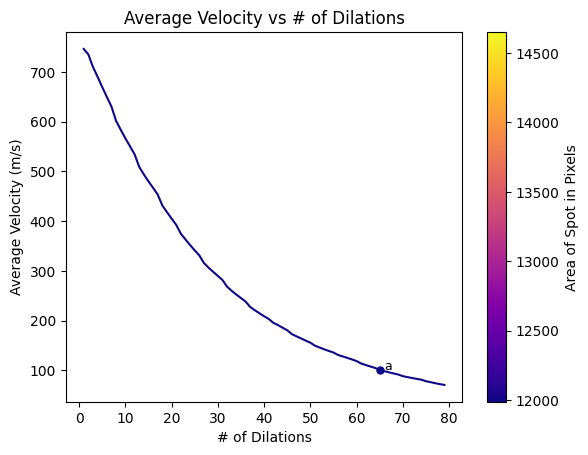

trying to plot...
0.8270729


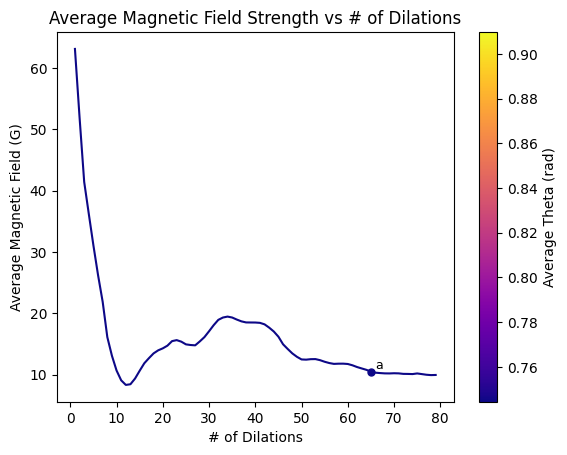

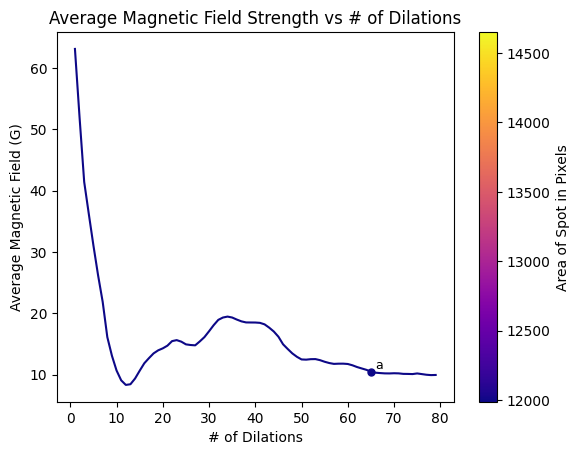

trying to plot...
0.8270729


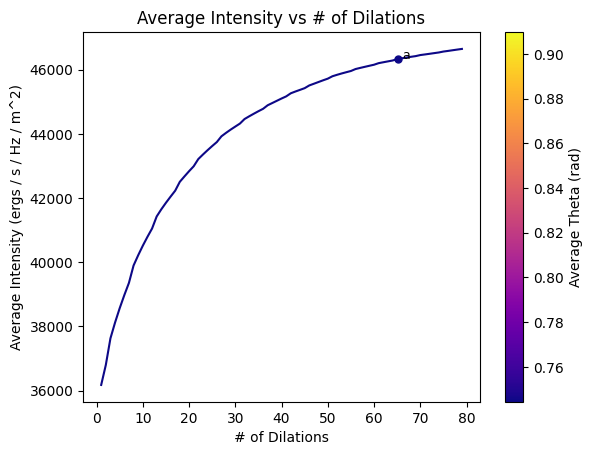

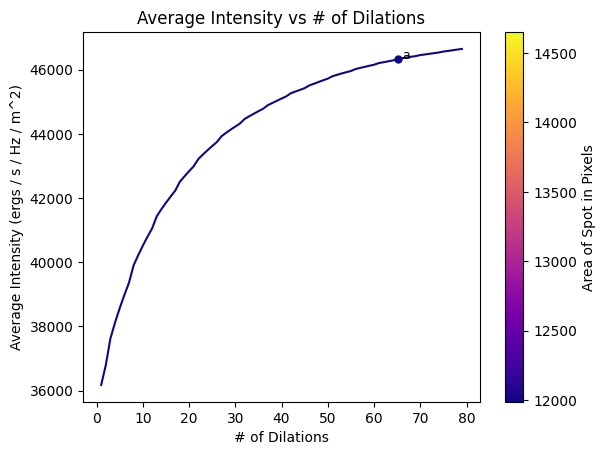

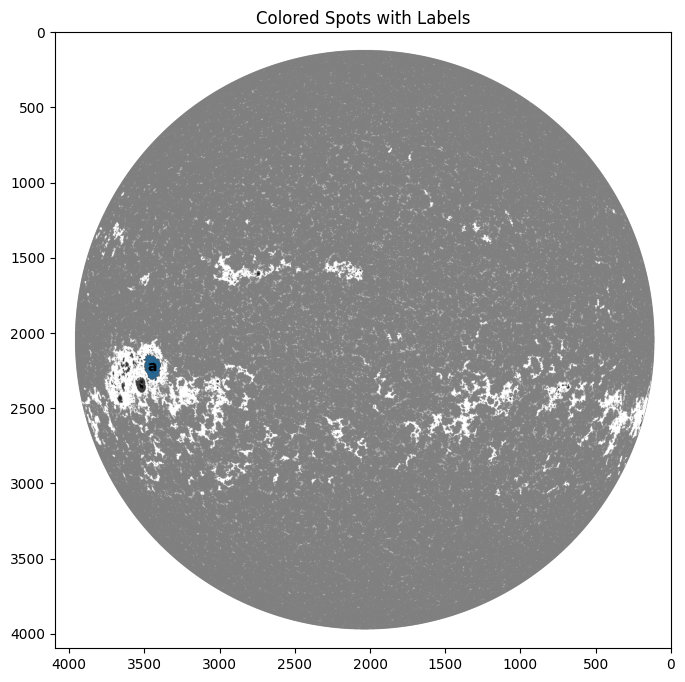

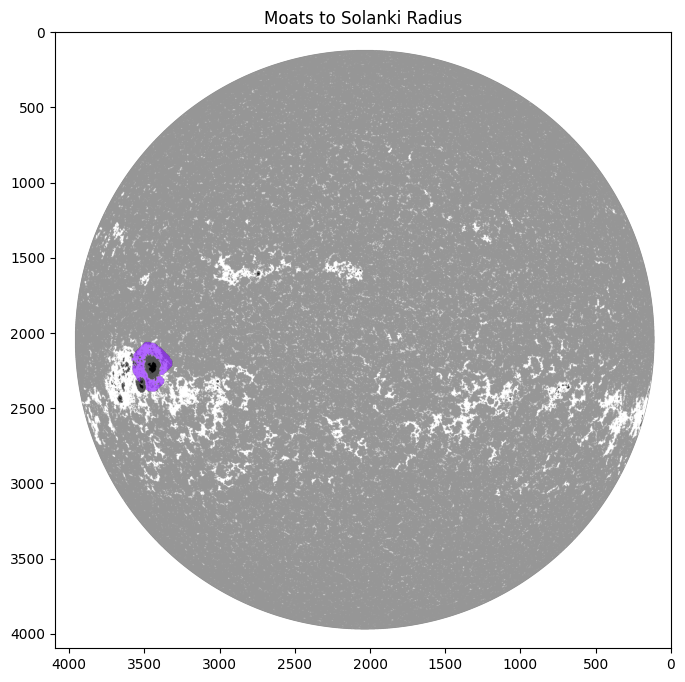

c:\Users\srugi\Documents\sdo-clv-pipeline\data


KeyboardInterrupt: 

In [11]:
moat_vels = []
moat_mags = []
moat_ints = []
moat_dilations = []
moat_areas = []
moat_thetas = []
moat_vals = []

for i in range (0, 8):
    # define the paths where files live
    con_file = os.path.join(data_dir, con_files[i])
    mag_file = os.path.join(data_dir, mag_files[i])
    dop_file = os.path.join(data_dir, dop_files[i])
    aia_file = os.path.join(data_dir, aia_files[i])
    print(data_dir)

    # create the SDOImage object instances
    con = SDOImage(con_file)     # continuum, Relative HMI continuum intensity
    mag = SDOImage(mag_file)     # magnetogram, magnetic field strength
    dop = SDOImage(dop_file)     # Dopplergram, LOS velocity
    aia = SDOImage(aia_file)     # AIA 1700 continuum filtergram, Relative 1700 Angstrom Continuum Intensity

    # do the coordinate transforms, etc.
    dop.calc_geometry()
    con.inherit_geometry(dop)
    mag.inherit_geometry(dop)

    aia.rescale_to_hmi(con) # reproject onto plate scale of HMI images

    # calculate the limb darkening correction
    con.calc_limb_darkening()
    aia.calc_limb_darkening()

    # correct magnetogram for foreshortening
    mag.correct_magnetogram()

    # calculate differential rot., meridional circ., obs. vel, grav. redshift, cbs
    dop.correct_dopplergram(fit_cbs=False)

    # set values to nan for mu less than mu_thresh
    mu_thresh = 0.1
    con.mask_low_mu(mu_thresh)
    dop.mask_low_mu(mu_thresh)
    mag.mask_low_mu(mu_thresh)
    aia.mask_low_mu(mu_thresh)

    mask = SunMask(con, mag, dop, aia, moat_vels, moat_mags, moat_ints, moat_dilations, moat_thetas, moat_areas, moat_vals)
    mask.mask_low_mu(mu_thresh)

    label_moats_on_sun(mask)

# plot
moat_vals, moat_dilations, moat_thetas, moat_areas = SunMask.get_moat_properties(mask)
print(moat_vals)
from sdo_clv_pipeline.plot_moats_data import plot_loop
plot_loop(moat_vals, moat_dilations, moat_thetas, moat_areas)